## imports

In [1]:
from collections import defaultdict
from dataclasses import dataclass
import itertools
import logging
import random
import json
import math
import numpy as np
import time
import torch
import sys

from omegaconf import OmegaConf
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
from pathlib import Path

from dataset import DataArgs, Dataset, iterate_batches
from basic_model import ModelArgs, Transformer

In [53]:
@dataclass
class OptimArgs:
    learning_rate: float = 0.2  # for SGD
    weight_decay: float = 1e-4  # for SGD
    momentum: float = 0.9  # for SGD
    batch_size: int = 512
    use_sgd: bool = True  # otherwise use AdamW


@dataclass
class TrainerArgs:
    optim_args: OptimArgs
    data_args: DataArgs
    model_args: ModelArgs
    max_iters: Optional[int] = None
    eval_delta: int = 5
    log_norms: bool = False
    log_probes: bool = False
    freeze_until: str = ''
    loss_head_only: bool = True
    bigram_outs_train: bool = False
    bigram_outs_test: bool = False
    num_data_workers: int = 60
    seed: int = 42
    save_dir: Optional[str] = None
    root_dir: str = ''


In [54]:
 args = TrainerArgs(
           optim_args=OptimArgs(),
           data_args=DataArgs(),
           model_args=ModelArgs()
        )

In [55]:
cfg = OmegaConf.merge(OmegaConf.structured(args))

In [56]:
ds = Dataset(cfg.data_args, train_test=None, bigram_outs=cfg.bigram_outs_train)
ds_test = Dataset(cfg.data_args, train_test=None, bigram_outs=cfg.bigram_outs_test)
ds_test.idxs = ds.idxs
cfg.model_args.vocab_size = ds.num_tokens

In [57]:
  
model = Transformer(cfg.model_args)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Transformer(
  (tok_embeddings): Embedding(65, 64)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): Attention(
        (wq): Identity()
        (wk): Linear(in_features=64, out_features=64, bias=False)
        (wv): Linear(in_features=64, out_features=64, bias=False)
        (wo): Linear(in_features=64, out_features=64, bias=False)
      )
    )
  )
  (output): Linear(in_features=64, out_features=65, bias=False)
)

Add attention hooks

In [58]:
attn_features = None
attn_features2 = None
attn_input_features = None
attn_scores = None
attn_scores2 = None
def attn0_hook(_, inp, outp):
    global attn_features, attn_input_features, attn_scores
    attn_input_features = inp[0].detach()
    attn_features = outp[0].detach()
    attn_scores = outp[1].detach()
model.layers[0].attention.register_forward_hook(attn0_hook)
def attn1_hook(_, inp, outp):
    global attn_scores2, attn_features2
    attn_features2 = outp[0].detach()
    attn_scores2 = outp[1].detach()
model.layers[1].attention.register_forward_hook(attn1_hook)

In [59]:
# memory probes
range_toks = torch.from_numpy(np.arange(ds.n_train_toks)).to(device)
def test_wo1():
    toks = model.tok_embeddings(range_toks)
    toks = model.layers[1].attention.wv(toks)
    toks = model.layers[1].attention.wo(toks)
    toks = model.output(toks)
    return (toks.argmax(-1) == range_toks).float().mean().item()

full_range_toks = torch.from_numpy(np.arange(ds.num_tokens)).to(device)
conds = torch.from_numpy(np.array(ds.cond)).to(device)
used_idxs = np.arange(ds.num_tokens)
if cfg.data_args.fixed_special_toks:
    used_idxs = np.setdiff1d(used_idxs, ds.idxs)
def test_ff1():
    toks = model.tok_embeddings(full_range_toks[used_idxs])
    toks = model.layers[1].ff(toks)
    toks = model.output(toks)
    return F.kl_div(F.log_softmax(toks, dim=1), conds[used_idxs], reduction='batchmean').item()

range_pos_toks = torch.from_numpy(np.arange(cfg.model_args.max_length)).to(device)
def test_wk0(cutoff=None):
    pe = model.pe[:cutoff,:]
    k = model.layers[0].attention.wk(pe[:-1])
    q = model.layers[0].attention.wq(pe[1:])
    return ((q @ k.t()).argmax(-1) == range_pos_toks[:pe.shape[0]-1]).float().mean().item()

wk1_range_toks = full_range_toks.clone()
if cfg.data_args.fixed_special_toks:
    wk1_range_toks = wk1_range_toks[ds.idxs]
def test_wk1():
    toksk = model.tok_embeddings(wk1_range_toks)
    toksk = model.layers[0].attention.wv(toksk)
    toksk = model.layers[0].attention.wo(toksk)
    toksk = model.layers[1].attention.wk(toksk)

    toksq = model.tok_embeddings(wk1_range_toks)
    toksq = model.layers[1].attention.wq(toksq)
    return ((toksq @ toksk.t()).argmax(-1) == range_toks[:wk1_range_toks.shape[0]]).float().mean().item()



In [60]:
cfg.freeze_until

''

In [61]:
# available params to potentially freeze:
print( list(name for name, p in model.named_parameters()))

['tok_embeddings.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'output.weight']


In [62]:
cfg.freeze_until = "300:layers.1.attention.wo.weight"

In [39]:
# initial param freezing
freeze_until = defaultdict(list)
to_freeze = []
if cfg.freeze_until:
    for kv in cfg.freeze_until.split(','):
        k, v = kv.split(':')
        k = int(k)
        to_freeze.append(v)
        freeze_until[k].append(v)

    for name, p in model.named_parameters():
        if name in to_freeze:
            p.requires_grad_(False)


In [40]:
freeze_until

defaultdict(list, {300: ['layers.1.attention.wo.weight']})

In [41]:
cfg.optim_args.use_sgd

True

In [42]:
if cfg.optim_args.use_sgd:
    optimizer = torch.optim.SGD(model.parameters(),
            lr=cfg.optim_args.learning_rate,
            weight_decay=cfg.optim_args.weight_decay,
            momentum=cfg.optim_args.momentum)
else:
    optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=cfg.optim_args.learning_rate,
            weight_decay=cfg.optim_args.weight_decay,
            betas=(0.9, 0.95),
            eps=1e-8)

In [43]:
# a test batch for experimentation
x_exp, out_exp = ds.gen_batch(np.random.default_rng(0), 128)
x_exp = x_exp[:,:ds.seq_length]

# OOD test data
x_test, out_test = ds_test.gen_batch(np.random.default_rng(0), 512)
x_t = torch.from_numpy(x_test[:,:ds.seq_length]).to(device)
y_t = torch.from_numpy(x_test[:,1:ds.seq_length + 1]).to(device)
outs_t = torch.from_numpy(out_test[:,:ds.seq_length]).to(device)

t = time.time()
t0 = t
res = []

In [44]:
print(cfg.root_dir)
print(cfg.save_dir)


None


In [45]:
cfg.save_dir=("./logs")

In [ ]:
if cfg.save_dir is not None:
    outdir = Path(cfg.root_dir) / Path(cfg.save_dir)
    outdir.mkdir(parents=True, exist_ok=True)
    # save params
    with open(outdir / 'params.json', 'w') as f:
        json.dump(dict(cfg), f, sort_keys=True, indent=4)


In [47]:
outfile = open(outdir / 'res.jsonl', 'w')

Extract from paper: 
We train our models using mini-batch SGD with momentum, where each
batch consists of 512 fresh sequences of length T = 256 sampled from our synthetic model. We use
a fixed learning rate and weight decay. Hyperparameters are given in Appendix E. Unless otherwise
noted, we use d = 128, random triggers with πq = πu and uniform output tokens. The reported
accuracies and losses are computed over each fresh batch before it is used for optimization, and
are averaged over relevant tokens: “in-context accuracy/loss” numbers only consider predictions
of output tokens on triggers starting at the second occurrence (the first is non-deterministic), while
“global loss” refers to average loss on non-trigger tokens.


In [48]:
print(cfg.max_iters)

None


In [26]:
cfg.max_iters =1000
cfg.eval_delta = 5
# number of triggers
cfg.data_args.k = 2


In [ ]:
data_args.k=5 data_args.fixed_special_toks=True \
        optim_args.use_sgd=True optim_args.learning_rate=0.03 optim_args.weight_decay=1e-4 optim_args.batch_size=512 \
        model_args.final_ffn=False model_args.freeze_embeddings=True model_args.freeze_output=True model_args.dim=256

In [51]:
print(cfg)

{'optim_args': {'learning_rate': 0.2, 'weight_decay': 0.0001, 'momentum': 0.9, 'batch_size': 512, 'use_sgd': True}, 'data_args': {'k': 0, 'seq_length': 256, 'show_latents': False, 'fixed_special_toks': False, 'special_toks_offset': 0, 'output_counter': True, 'no_repeat': False}, 'model_args': {'vocab_size': 65, 'dim': 64, 'max_length': 256, 'final_ffn': False, 'first_ffn': False, 'linear_final_ffn': True, 'linear_first_ffn': True, 'freeze_embeddings': False, 'freeze_output': False, 'tie_output': False, 'use_rope': False, 'sqrtd_embeddings': False, 'no_sqrtd': False, 'sin_cos': False}, 'max_iters': None, 'eval_delta': 5, 'log_norms': False, 'log_probes': False, 'freeze_until': '300:layers.1.attention.wo.weight', 'loss_head_only': True, 'bigram_outs_train': False, 'bigram_outs_test': False, 'num_data_workers': 60, 'seed': 42, 'save_dir': './logs', 'root_dir': ''}


In [50]:
print(f"{cfg.data_args.fixed_special_tokens=}")
print(f"{cfg.use_sgd=}")
print(f"{cfg.learning_rate=}")
print(f"{cfg.weight_decay=}")
print(f"{cfg.batch_size=}")

ConfigAttributeError: Key 'fixed_special_tokens' not in 'DataArgs'
    full_key: data_args.fixed_special_tokens
    reference_type=DataArgs
    object_type=DataArgs

In [27]:
all_results = []
i = 0
for i, (x, y, outs) in enumerate(iterate_batches(ds, batch_size=cfg.optim_args.batch_size, seed=cfg.seed)):
    print(f"Epoch {i}/{cfg.max_iters}")
    dt_data = time.time() - t
    if cfg.max_iters is not None and i >= cfg.max_iters:
        if cfg.save_dir is not None:
            outfile.close()
        break
    
    x = torch.from_numpy(x).to(device)
    y = torch.from_numpy(y).to(device)
    outs = torch.from_numpy(outs).to(device)

    if i in freeze_until:  # unfreeze params
        for name, p in model.named_parameters():
            if name in freeze_until[i]:
                p.requires_grad_(True)

    optimizer.zero_grad()
    pred = model(x)

    if cfg.loss_head_only:
        loss = F.cross_entropy(pred[outs >= 2], y[outs >= 2])
    else:
        loss = F.cross_entropy(pred.flatten(0, 1), y.flatten(0, 1))

    loss.backward()

    optimizer.step()
    dt = time.time() - t
    t = time.time()

    if i % cfg.eval_delta == 0:
        if cfg.data_args.k > 0:
            acc_tot = (pred.argmax(-1)[outs >= 1] == y[outs >= 1]).float().mean().item()
            sl = 10
            acc_start = (pred[:,:sl].argmax(-1)[outs[:,:sl] >= 1] == y[:,:sl][outs[:,:sl] >= 1]).float().mean().item()
            el = 500
            acc_end = (pred[:,-el:].argmax(-1)[outs[:,-el:] >= 2] == y[:,-el:][outs[:,-el:] >= 2]).float().mean().item()
            loss_bigram = F.cross_entropy(pred[outs == 0,:], y[outs == 0]).item()
            loss_head = F.cross_entropy(pred[outs >= 2,:], y[outs >= 2]).item()

            # first layer attn scores probe
            i1, i2 = torch.where(outs[:,:-1] >= 1)
            i1_start, i2_start = torch.where(outs[:,:-1] == 1)
            amax = attn_scores[:,0,:,:].argmax(-1)
            score_acc = (amax[i1, i2 + 1] == i2).float().mean().item()
            score_start_acc = (amax[i1_start, i2_start + 1] == i2_start).float().mean().item()

            # second layer attn scores probe (check that attended token's prev token has correct condition)
            i1, i2 = torch.where(outs >= 2)
            amax2 = attn_scores2.squeeze(1)[i1,i2,:].argmax(-1)
            score2_next_acc = (x[i1, amax2] == y[i1, i2]).float().mean().item()
            pred_attended_acc = (x[i1, amax2] == pred[i1,i2].argmax(-1)).float().mean().item()

            bad = (amax2 == 0).float().sum()
            tot = amax2.shape[0]
            i1 = i1[amax2 >= 1]
            i2 = i2[amax2 >= 1]
            amax2 = amax2[amax2 >= 1]
            score2_acc = (x[i1, amax2 - 1] == x[i1, i2]).float().sum().item() / tot

            # first layer attn score probe conditioned on locations attended by second layer
            score_cond_acc = (amax[i1, amax2] == amax2 - 1).float().mean().item()

            # second layer attn score probe conditioned on repeated tokens
            i1, i2 = torch.where((outs >= 2) & (x == y))
            amax1 = attn_scores.squeeze(1)[i1,i2,:].argmax(-1)
            score1_repeat_val_acc = (x[i1, amax1] == y[i1, i2]).float().mean().item()
            amax2 = attn_scores2.squeeze(1)[i1,i2,:].argmax(-1)
            score2_repeat_val_acc = (x[i1, amax2] == y[i1, i2]).float().mean().item()
            # score2_repeat_prev_acc = (amax2 == i2 - 1).float().mean().item()

            if True:  # cfg.log_probes:
                wo1_acc = test_wo1()
                if cfg.model_args.final_ffn:
                    ff1_loss = test_ff1()
                else:
                    ff1_loss = -1
                wk0_acc = test_wk0()
                wk0_64_acc = test_wk0(cutoff=64)
                wk1_acc = test_wk1()

            repeat_frac = (x[outs >= 1] == y[outs >= 1]).float().mean().item()

            # OOD test (NOTE: do this after the probes sinces it messes hooks!)
            with torch.no_grad():
                pred_t = model(x_t)
            acc_end_test = (pred_t[:,-el:].argmax(-1)[outs_t[:,-el:] >= 2] == y_t[:,-el:][outs_t[:,-el:] >= 2]).float().mean().item()

            logging.info(
                    f'''{i} ({dt_data:.2f}, {dt:.2f}, {t - t0:.2f}): loss: {loss.item():.4f} ({loss_bigram:.4f}, {loss_head:.4f}), \
acc: {acc_tot:.4f} ({acc_end:.4f} / {acc_end_test:.4f}) \
probes: {score_start_acc:.4f} / {score2_acc:.4f} / {score_cond_acc:.4f} / {pred_attended_acc:.4f} ({repeat_frac:.4f})'''
)
            if cfg.log_probes:
                logging.info(f'memory probes wk0: {wk0_acc:.4f} ({wk0_64_acc:.4f}), wk1: {wk1_acc:.4f}, wo1: {wo1_acc:.4f}, ff1: {ff1_loss:.4f}')

            curr_res = {'iter': i, 'loss': loss.item(), 'loss_bigram': loss_bigram, 'loss_head': loss_head,
                        'acc_tot': acc_tot, 'acc_start': acc_start, 'acc_end': acc_end, 'acc_end_test': acc_end_test,
                        'score_acc': score_acc, 'score_start_acc': score_start_acc, 'score2_acc': score2_acc,
                        'score_cond_acc': score_cond_acc,
                        'pred_attended_acc': pred_attended_acc, 'repeat_frac': repeat_frac,
                        'wk0_acc': wk0_acc, 'wk0_64_acc': wk0_64_acc, 'wk1_acc': wk1_acc, 'wo1_acc': wo1_acc, 'ff1_loss': ff1_loss}

            for name, p in model.named_parameters():
                if p.requires_grad:
                    curr_res['norm_' + name] = p.norm().item()
                    curr_res['gradnorm_' + name] = p.grad.norm().item()

            if cfg.log_norms:
                param_norms = {
                        'wk': [layer.attention.wk.weight.norm().item() for layer in model.layers],
                        'wv': [layer.attention.wv.weight.norm().item() for layer in model.layers],
                        'wo': [layer.attention.wo.weight.norm().item() for layer in model.layers],
                        }
                grad_norms = {
                        'wk': [layer.attention.wk.weight.grad.norm().item() for layer in model.layers if layer.attention.wk.weight.requires_grad],
                        'wv': [layer.attention.wv.weight.grad.norm().item() for layer in model.layers if layer.attention.wv.weight.requires_grad],
                        'wo': [layer.attention.wo.weight.grad.norm().item() for layer in model.layers if layer.attention.wo.weight.requires_grad],
                        }
                logging.info(repr(param_norms))
                logging.info(repr(grad_norms))
            all_results.append(curr_res)

Epoch 0/1000


ZeroDivisionError: float division by zero

In [ ]:
%tb

In [23]:
import pandas as pd
df= pd.DataFrame.from_records(all_results)
df.head()

NameError: name 'pd' is not defined

In [ ]:
df.to_pickle("df.pkl")

In [2]:
import json

In [65]:
with open("logs/2025_01_20_21_05_40_res.json", "r") as f:
    res = json.load(f)

In [66]:
import pandas as pd
df = pd.DataFrame.from_records(res)

In [67]:
df.head()

,iter,loss,loss_bigram,loss_head,acc_tot,acc_start,acc_end,acc_end_test,score_acc,score_start_acc,...,wk0_64_acc,wk1_acc,wo1_acc,ff1_loss,norm_layers.0.attention.wk.weight,gradnorm_layers.0.attention.wk.weight,norm_layers.1.attention.wk.weight,gradnorm_layers.1.attention.wk.weight,norm_layers.1.attention.wo.weight,gradnorm_layers.1.attention.wo.weight
0,0,4.575071,4.450954,4.575071,0.011630,0.009340,0.011863,0.013984,0.021717,0.164777,...,0.031746,0.0,0.046154,-1,9.254825,0.072896,9.249850,0.104189,NaN,NaN
1,1,4.540353,4.455684,4.540353,0.013311,0.007910,0.013244,0.014061,0.020190,0.164541,...,0.031746,0.0,0.046154,-1,9.254778,0.081149,9.249804,0.119260,NaN,NaN
2,2,4.599963,4.452395,4.599963,0.012750,0.013734,0.012752,0.014164,0.020342,0.155236,...,0.031746,0.0,0.046154,-1,9.254715,0.088820,9.249736,0.141720,NaN,NaN
3,3,4.557446,4.450966,4.557446,0.013546,0.013624,0.013306,0.014138,0.021539,0.160848,...,0.031746,0.0,0.046154,-1,9.254651,0.087281,9.249665,0.155967,NaN,NaN
4,4,4.558529,4.447713,4.558529,0.012972,0.013486,0.013000,0.014395,0.022542,0.161878,...,0.031746,0.0,0.046154,-1,9.254571,0.064013,9.249595,0.117203,NaN,NaN


In [68]:
print(df.columns)

Index(['iter', 'loss', 'loss_bigram', 'loss_head', 'acc_tot', 'acc_start',
       'acc_end', 'acc_end_test', 'score_acc', 'score_start_acc', 'score2_acc',
       'score_cond_acc', 'pred_attended_acc', 'repeat_frac', 'wk0_acc',
       'wk0_64_acc', 'wk1_acc', 'wo1_acc', 'ff1_loss',
       'norm_layers.0.attention.wk.weight',
       'gradnorm_layers.0.attention.wk.weight',
       'norm_layers.1.attention.wk.weight',
       'gradnorm_layers.1.attention.wk.weight',
       'norm_layers.1.attention.wo.weight',
       'gradnorm_layers.1.attention.wo.weight'],
      dtype='object')


In [70]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.7 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 90.3 MB/s eta 0:00:0031m107.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 92.7 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


<Axes: >

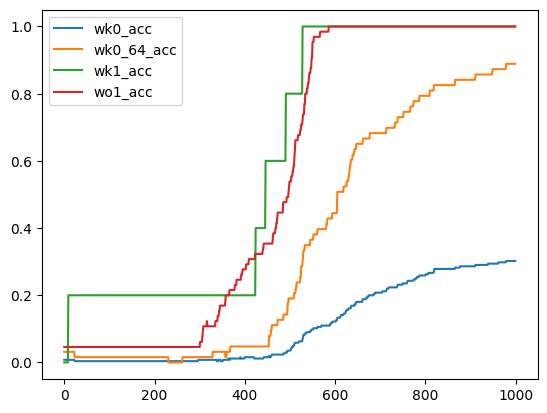

In [71]:

df[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc']].plot()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

### Training without any frozen layer

In [5]:
with open("logs/2025_01_23_11_36_21_res.json", "r") as f:
    res = json.load(f)

In [8]:
df = pd.DataFrame.from_records(res)
df.head()

,iter,loss,loss_bigram,loss_head,acc_tot,acc_start,acc_end,acc_end_test,score_acc,score_start_acc,...,wk0_64_acc,wk1_acc,wo1_acc,ff1_loss,norm_layers.0.attention.wk.weight,gradnorm_layers.0.attention.wk.weight,norm_layers.1.attention.wk.weight,gradnorm_layers.1.attention.wk.weight,norm_layers.1.attention.wo.weight,gradnorm_layers.1.attention.wo.weight
0,0,4.452343,4.547057,4.452343,0.020284,0.016678,0.020687,0.024813,0.020763,0.136032,...,0.0,0.0,0.000000,-1,9.253633,0.070591,9.221467,0.074733,9.226016,0.430858
1,1,4.418415,4.545830,4.418415,0.022948,0.015162,0.023474,0.025839,0.019256,0.124640,...,0.0,0.0,0.000000,-1,9.253574,0.105726,9.221380,0.103797,9.226062,0.507344
2,2,4.454323,4.552030,4.454323,0.022301,0.015697,0.022837,0.027712,0.020175,0.130595,...,0.0,0.0,0.000000,-1,9.253502,0.105986,9.221256,0.093002,9.226281,0.549781
3,3,4.417518,4.548048,4.417518,0.023801,0.014305,0.024496,0.031253,0.018910,0.126766,...,0.0,0.0,0.015385,-1,9.253420,0.122545,9.221100,0.125804,9.226838,0.582880
4,4,4.419648,4.534748,4.419648,0.022936,0.014835,0.023798,0.035538,0.019293,0.125860,...,0.0,0.0,0.030769,-1,9.253332,0.073887,9.220927,0.079673,9.227844,0.442487


<Figure size 640x480 with 0 Axes>

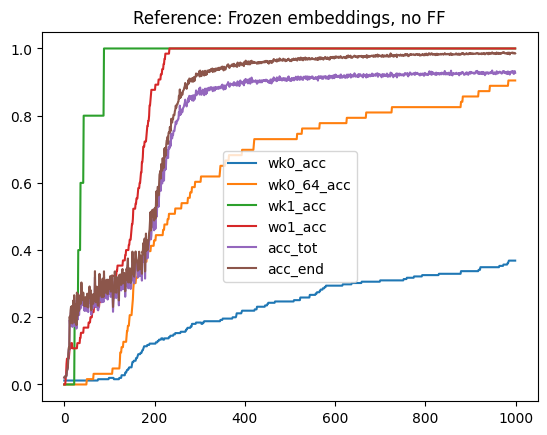

In [14]:
with open("logs/2025_01_23_11_36_21_res.json", "r") as f:
    res = json.load(f)
df = pd.DataFrame.from_records(res)
plt.figure()
df[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("Reference: Frozen embeddings, no FF")
plt.savefig("data/2025_01_23_11_36_21_res.png")

### Training with noise

<Figure size 640x480 with 0 Axes>

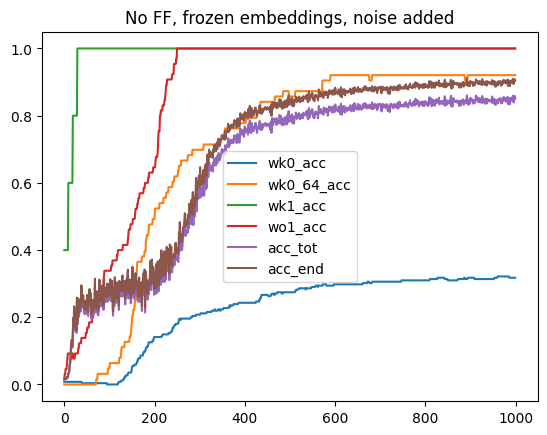

In [15]:
with open("logs/2025_01_23_11_52_15_res.json", "r") as f:
    res = json.load(f)
df_2025_01_23_11_52_15 = pd.DataFrame.from_records(res)
plt.figure()
df_2025_01_23_11_52_15[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("No FF, frozen embeddings, noise added")
plt.savefig("data/2025_01_23_11_52_15_res.png")

### Training with one FF layer

<Figure size 640x480 with 0 Axes>

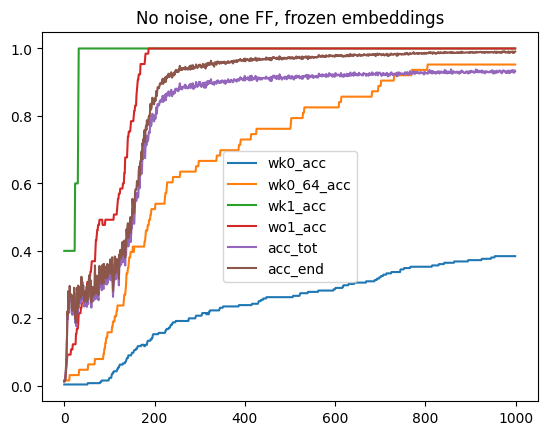

In [16]:
with open("logs/2025_01_23_11_38_11_res.json", "r") as f:
    res = json.load(f)
df_2025_01_23_11_38_11 = pd.DataFrame.from_records(res)
plt.figure()
df_2025_01_23_11_38_11[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("No noise, one FF, frozen embeddings")
plt.savefig("data/2025_01_23_11_38_11_res.png")

## No FF, frozen embeddings, longer training

In [4]:
import json

<Figure size 640x480 with 0 Axes>

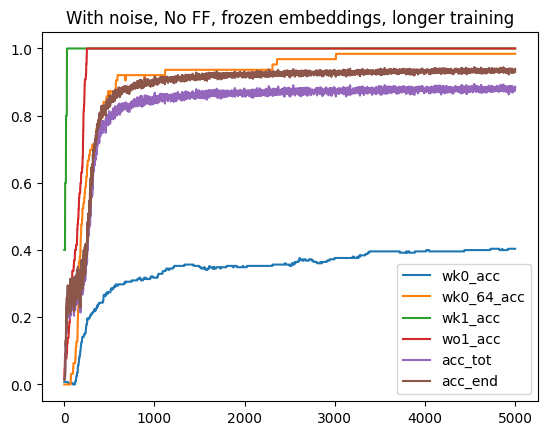

In [17]:
with open("logs/2025_01_23_14_47_44_res.json", "r") as f:
    res = json.load(f)
df_2025_01_23_14_47_44_res= pd.DataFrame.from_records(res)
plt.figure()
df_2025_01_23_14_47_44_res[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("With noise, No FF, frozen embeddings, longer training")
plt.savefig("data/2025_01_23_14_47_44_res.png")

## No FF, training embeddings
2025_01_23_14_48_36

<Figure size 640x480 with 0 Axes>

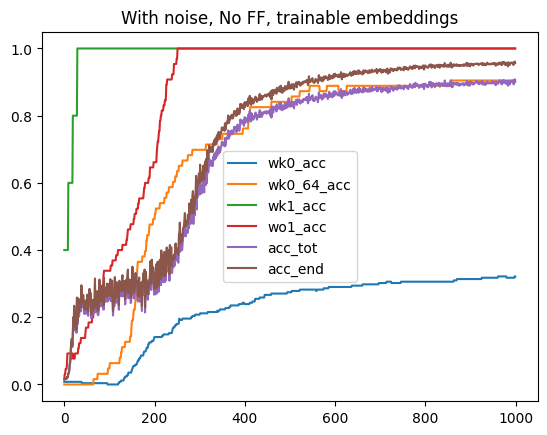

In [18]:
with open("logs/2025_01_23_14_48_36_res.json", "r") as f:
    res = json.load(f)
df_2025_01_23_14_48_36_= pd.DataFrame.from_records(res)
plt.figure()
df_2025_01_23_14_48_36_[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("With noise, No FF, trainable embeddings")
plt.savefig("data/2025_01_23_14_48_36_res.png")

## One FF, trainable embeddings
2025_01_23_14_48_50

<Figure size 640x480 with 0 Axes>

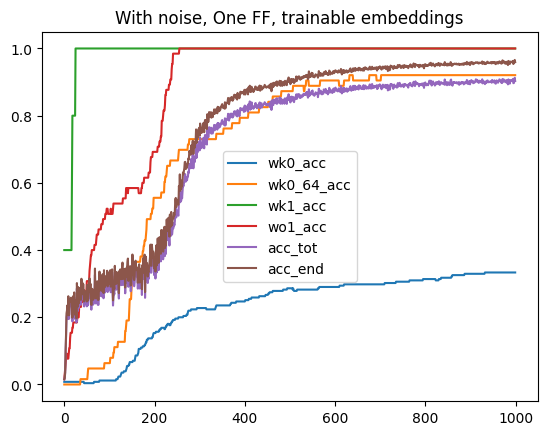

In [19]:
with open("logs/2025_01_23_14_48_50_res.json", "r") as f:
    res = json.load(f)
df_longer_training= pd.DataFrame.from_records(res)
plt.figure()
df_longer_training[['wk0_acc','wk0_64_acc', 'wk1_acc', 'wo1_acc', 'acc_tot', 'acc_end']].plot()
plt.title("With noise, One FF, trainable embeddings")
plt.savefig("data/2025_01_23_14_48_50_res.png")

### Comparison plots

In [ ]:
fig, axes = plt.subplots(2,3)
plt.suptitle("Results when adding noise to embeddings")

df1.plot(ax=axes[0,0]).